##### Import Libraries

In [21]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras import models
from keras import layers
from keras import optimizers


print(tf.__version__)

2.3.0


##### Mount Drive to access Data

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# unzip the folder
from zipfile import ZipFile
filename = "drive/My Drive/JF30-1.zip"
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print("Done!")

Done!


##### Import Data

In [24]:
classlabels = open("classlabels.txt", "r")
image = []
label = []

for line in classlabels:
    words = line.split()
    image.append(words[0][:-1])
    label.append(words[1])

df = pd.DataFrame([], columns = ["image", "label"])
df['image'] = image
df['label'] = label


df2 = df.reindex(np.random.permutation(df.index))
df2.head()

,image,label
28,JFT_00078.jpg,3
1136,JFT_00936.jpg,20
1232,JFT_01096.jpg,23
863,JFT_00485.jpg,10
536,JFT_01421.jpg,29


In [25]:
df2.shape

(1479, 2)

In [26]:
train_df = df2.head(1200)
test_df = df2.tail(279)

##### Preprocess Dataset

In [27]:
#Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)
# Data generator for training data
train_generator = train_datagen.flow_from_dataframe(
dataframe=train_df,
x_col = "image",
y_col = "label",
directory="./jpg/",
target_size=(128, 128))

Found 1200 validated image filenames belonging to 30 classes.


In [28]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)
# Data Generator for Test data
test_generator = test_datagen.flow_from_dataframe(
dataframe=test_df,
x_col = "image",
y_col = "label",
directory="./jpg/",
class_mode = "categorical",
target_size=(128, 128),
shuffle=False)

Found 279 validated image filenames belonging to 30 classes.


##### Baseline

In [29]:
print("Distribution of testing target variable::")
frequency = test_df['label'].value_counts(normalize =True)
print(frequency*100)
#Baseline is 5.37%

Distribution of testing target variable::
29    5.376344
11    5.017921
19    5.017921
23    5.017921
24    5.017921
22    4.659498
5     4.659498
6     4.659498
10    4.301075
2     3.942652
9     3.942652
4     3.942652
3     3.584229
28    3.584229
14    3.584229
13    3.225806
18    3.225806
27    3.225806
12    3.225806
7     3.225806
20    3.225806
17    2.508961
8     2.508961
25    2.508961
21    1.792115
26    1.433692
16    1.433692
15    1.075269
30    0.716846
1     0.358423
Name: label, dtype: float64


##### Load VGG Model

In [30]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

##### Train last 4 layer

In [31]:
for layer in vgg_conv.layers[:-4]:
  layer.trainable = False

# To chk trainable status
for layer in vgg_conv.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f482344fb70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f48273592b0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4823456518> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4823456908> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f48273592e8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4831e7cb00> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4825564f28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f48315a05c0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f48315ad438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f48315ad860> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f48315b8438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

##### Build Model

In [32]:
model = models.Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(30))
model.add(Activation('softmax'))  
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)               

In [33]:
## Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# Train model
history = model.fit_generator(train_generator,
epochs=40,
validation_data=test_generator,
verbose=1)

Epoch 1/40
38/38 [==============================] - 312s 8s/step - loss: 2.2711 - accuracy: 0.3625 - val_loss: 22.3144 - val_accuracy: 0.1398
Epoch 2/40
38/38 [==============================] - 310s 8s/step - loss: 1.0220 - accuracy: 0.6783 - val_loss: 5.4425 - val_accuracy: 0.3763
Epoch 3/40
38/38 [==============================] - 308s 8s/step - loss: 0.6869 - accuracy: 0.7800 - val_loss: 3.9732 - val_accuracy: 0.3548
Epoch 4/40
38/38 [==============================] - 306s 8s/step - loss: 0.4723 - accuracy: 0.8575 - val_loss: 0.5427 - val_accuracy: 0.8100
Epoch 5/40
38/38 [==============================] - 312s 8s/step - loss: 0.3804 - accuracy: 0.8925 - val_loss: 1.4275 - val_accuracy: 0.6201
Epoch 6/40
38/38 [==============================] - 307s 8s/step - loss: 0.3454 - accuracy: 0.8867 - val_loss: 1.2924 - val_accuracy: 0.6344
Epoch 7/40
38/38 [==============================] - 311s 8s/step - loss: 0.2958 - accuracy: 0.9083 - val_loss: 0.3002 - val_accuracy: 0.9140
Epoch 8/40
3

In [35]:
print("Minimum accuracy of Model: ", min(history.history['accuracy']))
print("Maximum accuracy of Model: ", max(history.history['accuracy']))

Minimum accuracy of Model:  0.36250001192092896
Maximum accuracy of Model:  0.9916666746139526


In [36]:
print("Minimum accuracy of validation: ", min(history.history['val_accuracy']))
print("Maximum accuracy of validation: ", max(history.history['val_accuracy']))

Minimum accuracy of validation:  0.13978494703769684
Maximum accuracy of validation:  0.9534050226211548


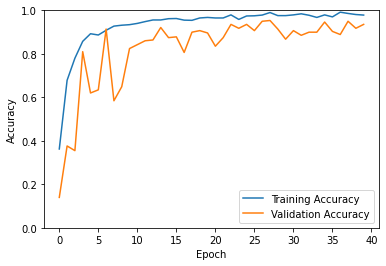

In [37]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),
           label='Training Accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Validation Accuracy')
  plt.legend()
  plt.ylim([0, 1])

plot_history(history)

##### Classification Report

In [ ]:
import sklearn.metrics as metrics
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division='warn')
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         7
          13       0.93      1.00      0.96        13
          14       0.92      1.00      0.96        11
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00         7
          18       1.00      1.00      1.00        12
          19       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        11
          20       0.90      0.90      0.90        10
          21       1.00      0.75      0.86         8
          22       0.85      1.00      0.92        11
          23       1.00      0.88      0.94        17
          24       1.00      1.00      1.00        12
          25       0.93    

##### Inference 

*  Using Fine tuning technique to train CNN Classification Model for the Jena Flowers dataset with 30 classes. 
*  The pretrained model used  is VGG16 and the last 4 layers of the model is trained where as rest of the layers are freezed. 
*  Initial layers  are intact and  later layers are retrained. This technique is good at adapting to the new data.
*  The baseline of the model is 5.37% and it is calculated using majority classification rule. 
*  The model and validation accuracy is exceeding baseline accuracy. The maximum validation accuracy is 95.3%.